## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

### (i) Finding the corners in the given chessboard images for calibrating the camera

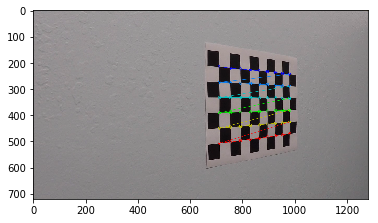

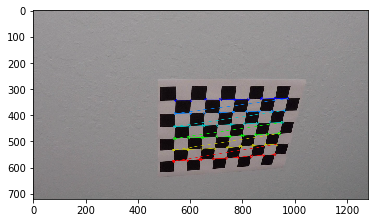

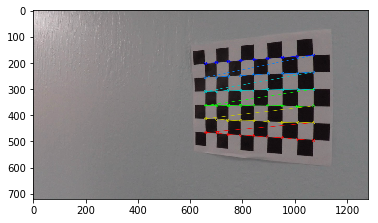

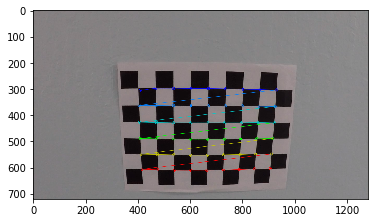

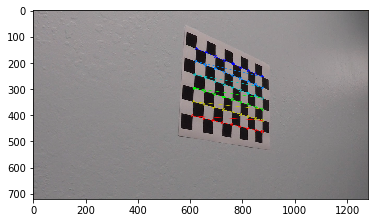

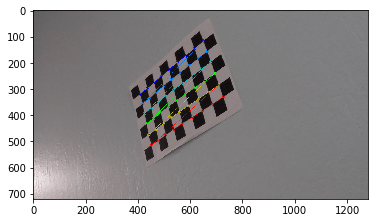

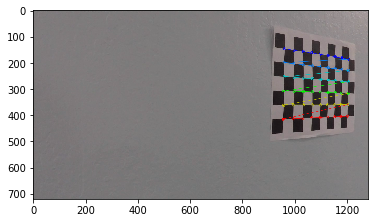

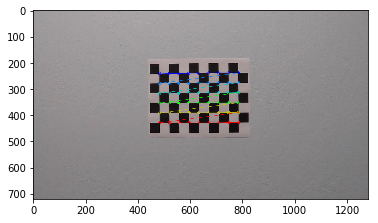

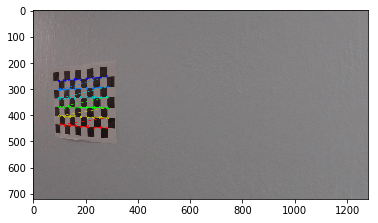

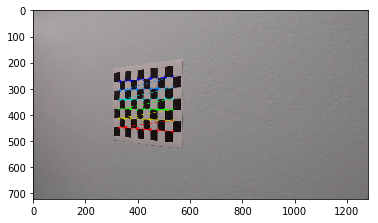

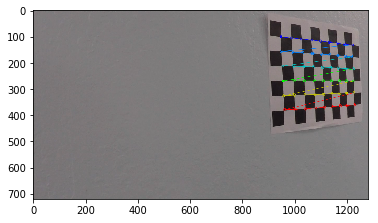

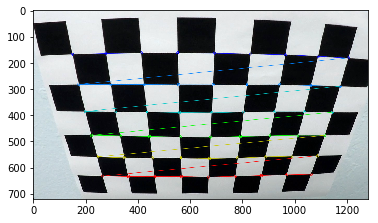

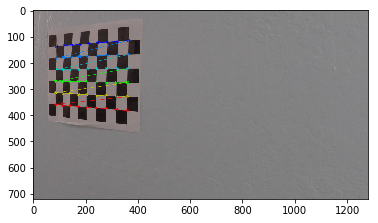

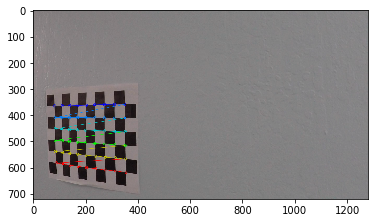

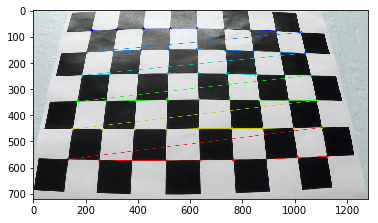

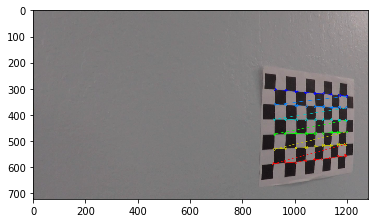

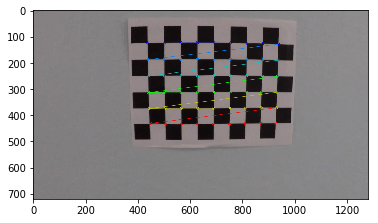

In [1]:
# Importing the required packages and libraries 
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname) # Reading in the image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Converting BGR to GRAY

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img, cmap='gray')
        plt.show()
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

### (ii) Calculating the camera calibration matrix and distortion coefficients

In [2]:
image_size = (img.shape[1], img.shape[0]) # Saving the size of the image
# Extracting the camera calibration matrix and distortion coefficients 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
# Defining pickle variables to store the calibration matrix and distortion coefficients to be used later
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )

## Apply a distortion correction to raw images

### (i) First, making one of our calibration image as undistorted image for verification 

Text(0.5,1,'Undistorted Image')

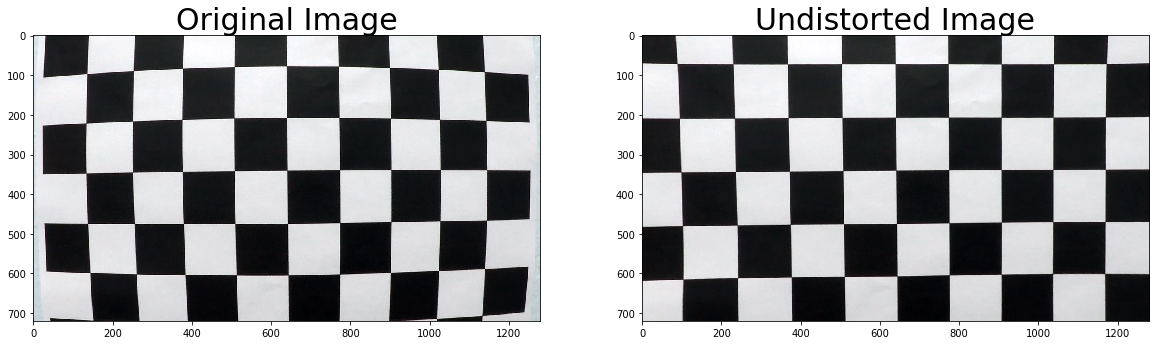

In [3]:
# Here opening the pickle files to extract the calibration matrix and distortion coefficients
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]
# Reading in an image
raw_image = cv2.imread('../camera_cal/calibration1.jpg')
# Undistorting our image using the matrix and the coefficients 
undistorted_image = cv2.undistort(raw_image, mtx, dist, None, mtx)

# Visualizing the undistortion in our given image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

We can clearly observe that the radial distortion of the calibration test image is undistorted properly by the OpenCV function, so now we can test this on our test images.

### (ii) Now, applying undistort function to our test images

Text(0.5,1,'Undistorted Image')

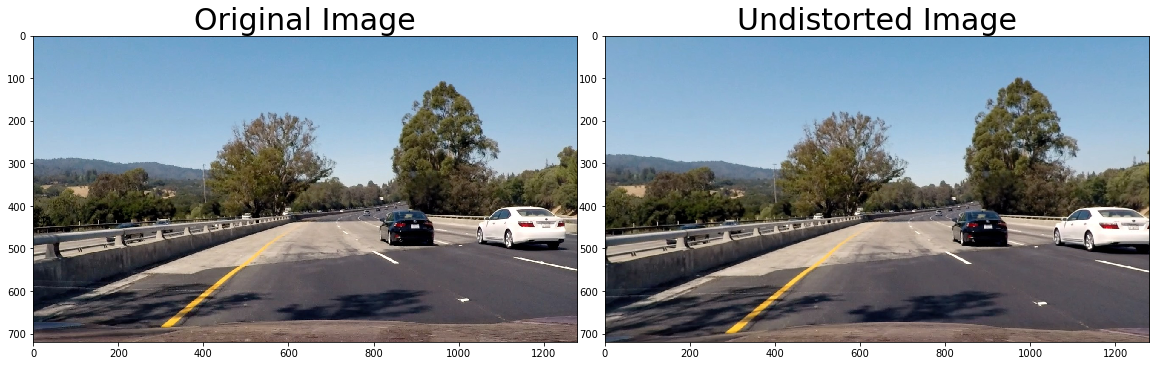

In [4]:
# testing our undistortion on some test image

test_image = cv2.imread('../test_images/test4.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

undistorted_test_image = cv2.undistort(test_image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_test_image)
ax2.set_title('Undistorted Image', fontsize=30)

## Applying a Perspective Transform

Text(0.5,1,'Perspective Transform Image')

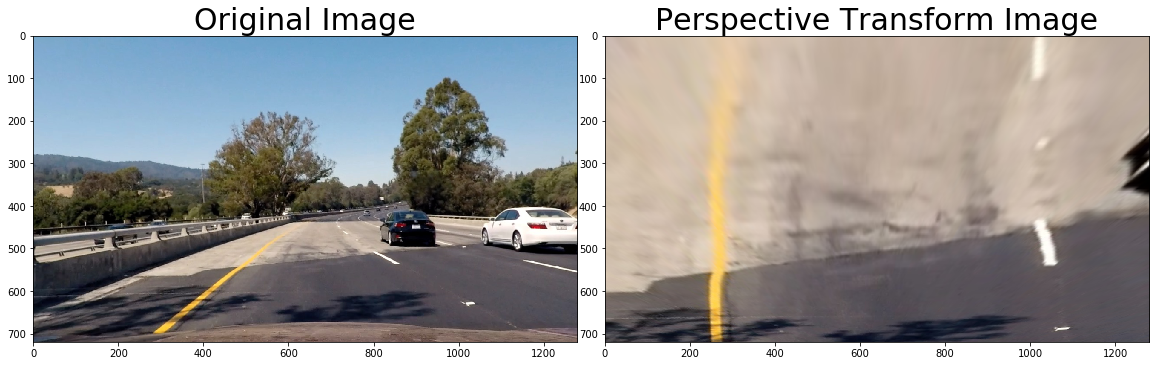

In [6]:
#test_img_perp = cv2.imread('../test_images/test4.jpg')
test_img_perp = undistorted_test_image
undistorted_test_image = cv2.cvtColor(test_img_perp, cv2.COLOR_BGR2RGB) # Converting the BGR to RGB
# Defining a perspective transform function which does the warping of perspective also
def perspective_transform(image):
    height, width = image.shape[0:2]
    src = np.float32(
        [
            [580.0, 460.0],
            [740.0, 460.0],      # Defining the source coordinates
            [1100.0, 670.0],
            [270.0, 670.0],
        ]
    )
    dst = np.float32(
        [
            [200.0, 0],
            [width - 200.0, 0], # Defining the destination coordinates for the perspective image
            [width - 200.0, height],
            [200.0, height],
        ]
    )

    M = cv2.getPerspectiveTransform(src, dst) # Calculating the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Calculating the inverse perspective transform matrix
    warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR) # Warped Perspective Transform
    return warped, M, Minv

warped_image, M, Minv = perspective_transform(undistorted_test_image)
# Visualize Perspective Transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undistorted_test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_image)
ax2.set_title('Perspective Transform Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

### (i) Selecting the HLS Color Space

Text(0.5,1,'HLS S-Channel')

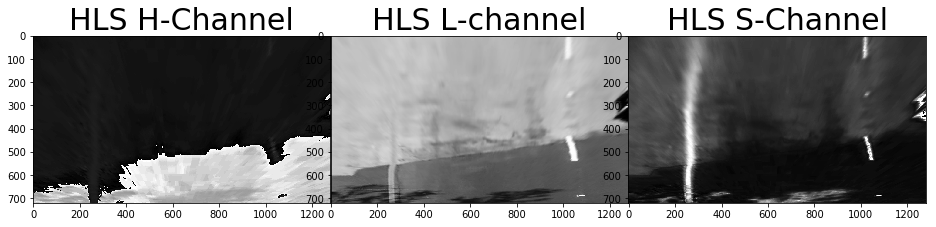

In [7]:
# Here we are extracting the HLS color space channels individually to visualize them later
warped_image_HLS = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)
warped_image_H = warped_image_HLS[:,:,0]
warped_image_L = warped_image_HLS[:,:,1]
warped_image_S = warped_image_HLS[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(warped_image_H, cmap='gray')
axs[0].set_title('HLS H-Channel', fontsize=30)
axs[1].imshow(warped_image_L, cmap='gray')
axs[1].set_title('HLS L-channel', fontsize=30)
axs[2].imshow(warped_image_S, cmap='gray')
axs[2].set_title('HLS S-Channel', fontsize=30)

As we can clearly observe from the HLS channel images that the lane lines are more prominently visible in the L & S channel. Therefore, we are going to utilize these two channels only to properly detect the lane lines.

### (ii) We define a function for Absolute Sobel Threshold using L & S channels

In [8]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255), sobel_kernel=3):
    thresh_min, thresh_max = thresh
    s_thresh = (120, 255)
    l_thresh = (30, 255)
    
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    H = hls_image[:,:,0]
    L = hls_image[:,:,1]
    S = hls_image[:,:,2]
    
    if orient == 'x':
        sobel = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    l_sobel = np.zeros_like(scaled_sobel)
    l_sobel[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(L)
    l_binary[(L >= l_thresh[0]) & (L <= l_thresh[1])] = 1
    
    binary_output = np.zeros_like(l_sobel)
    binary_output[((l_binary == 1) & (s_binary == 1) | (l_sobel==1))] = 1  
    
    return binary_output    

In the above function, I have included the L and S channel for consideration because we saw earlier that in L and S channels we are able to clearly observe the lane lines.

### (iii) Now we define a function to calculate the Magnitude Sobel Threshold

In [9]:
def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output

### (iv) Here we define a function which calculates the Directions Sobel Threshold

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):   
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dirs = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(dirs)
    binary_output[(dirs >= thresh[0]) & (dirs <= thresh[1])] = 1
    
    return binary_output

### (v) Finally, we combine the Magnitude and Directions Threshold to extract our Binary Image

In [11]:
def combined_thresh(img, sobel_kernel=3, abs_thresh=(15,255), _mag_thresh=(15,255), dir_thresh=(0, np.pi/2)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=abs_thresh)
    
    mag_binary = mag_thresh(img, sobel_kernel=sobel_kernel, thresh=_mag_thresh)
    
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

### (vi) We Plot our Binary Image

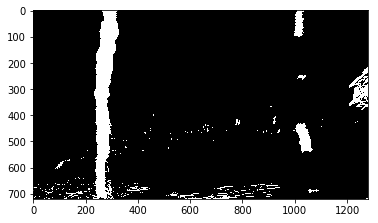

In [12]:
warped_binary = combined_thresh(warped_image, sobel_kernel=3, abs_thresh=(20,255), _mag_thresh=(20,255), dir_thresh=(0, np.pi/2))

plt.imshow(warped_binary, cmap='gray')

## Detect lane pixels and fit to find the lane boundary - Lane Lines Detection

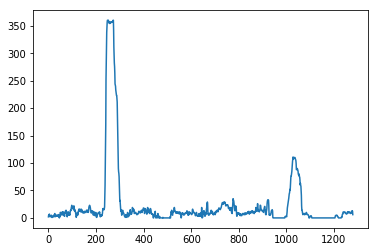

In [13]:
histogram_of_lanes = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram_of_lanes)

As we observe the Histogram closely, we can see there are two main peaks occuring near the x coordinate values 200 and 1000, which suggests that we have lane lines around that region

### (ii) Here, we are implementing the sliding window and fitting a 2nd order polynomial to our lane lines

In [14]:
def sliding_window_poly2fit(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img       

### (iii) Now, we define a function to visualize the result of our sliding window boxes and their fitting in the lane lines

In [15]:
def visualize_polyfit(img, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure(figsize = (10,5))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

### (iv) Now, we visualize our results 

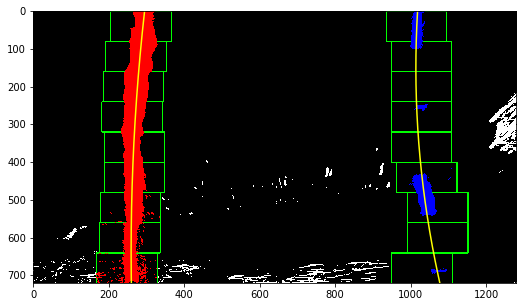

In [16]:
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding_window_poly2fit(warped_binary)

visualize_polyfit(warped_binary, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

Now, from the above image we can carefully observe that the small rectangluar boxes (i.e. sliding windows) are able to capture our lane lines, but since the boxes are moving left and right continuously to capture the line curves, so, we will be using a customized region of interest method to draw a slightly thick boundary line along our lines to be more efficient. 

Also, this will help us not to use the full algorithm of sliding windows again at each video frame, which will improve our efficiency. Now, to do this we will take our left fit and right fit values we obtained from our sliding window function along with a parameter called margin to determine our activated pixels in the shaded boundary line.

### (v) Defining a function to extract our customized region of interest and fit a 2nd order polynomial 

In [17]:
def shaded_boundary_line(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds

### (vi) We define our function to plot the shaded boundary lines

In [18]:
def visualize_shaded_boundary_line(binary_warped, out_img, left_fitx, right_fitx, left_lane_inds, right_lane_inds):
    margin = 80    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.figure(figsize = (10,5))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

### (vii) We call the function to visualize our shaded boundary line on the lane curves

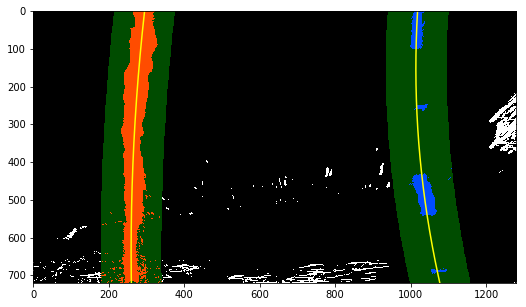

In [19]:
out_img, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = shaded_boundary_line(warped_binary, left_fit, right_fit)

visualize_shaded_boundary_line(warped_binary, out_img, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

## Determine the curvature of the lane and vehicle position with respect to center.

### (i) Defining a function to measure the curvature of our road by calculating the left and right lane radii of curvature

In [20]:
def measure_curvature(binary_warped, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

### (ii) Defining a function to measure our car position with respect to the lane center position

In [21]:
def measure_car_position(binary_warped, left_fit, right_fit):
    xm_per_pix = 3.7/700
    car_position = binary_warped.shape[1]/2
    height = binary_warped.shape[0]
    
    left_fit_x = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_fit_x = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    
    lane_center_position = (right_fit_x + left_fit_x) /2
    
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return center_dist

### (iii) Printing the values of left, right curvature and car position with respect to lane center

In [22]:
left_curverad, right_curverad = measure_curvature(warped_binary, left_lane_inds2, right_lane_inds2)

print(left_curverad, 'm', right_curverad, 'm')

car_pos = measure_car_position(warped_binary, left_fit2, right_fit2)

print(car_pos, 'm')

1433.1269663946957 m 838.8893329588586 m
-0.16487512022115608 m


## Warp the detected lane boundaries back onto the original image.

### (i) Defining a function to warp the detected lane boundaries onto our original image

In [23]:
def warp_lanes_onto_original(original_img, binary_img, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result

### (ii) Displaying our original warped image

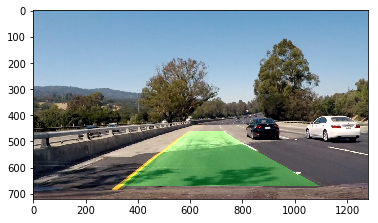

In [26]:
new_img = warp_lanes_onto_original(test_image, warped_binary, left_fit, right_fit, Minv)
plt.imshow(new_img)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### (i) A function to return our warped image with curvature data shown on the top left corner

In [27]:
def show_curvature_data(img, curv_rad, car_pos):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:02.2f}'.format(curv_rad/1000) + 'Km'
    cv2.putText(img, text, (30,70), font, 1.5, (0,255,0), 2, cv2.LINE_AA)
    
    text = 'Car pos. from center: ' + '{:02.3f}'.format(car_pos) + 'm'
    cv2.putText(img, text, (30,120), font, 1.5, (0,255,0), 2, cv2.LINE_AA)
    
    return img

### (ii) Displaying our image with the curvature data shown

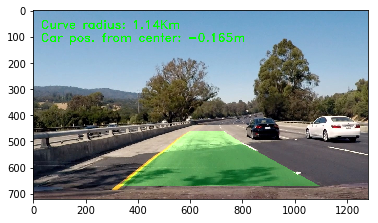

In [28]:
final_img = show_curvature_data(new_img, (left_curverad + right_curverad)/2, car_pos)

plt.imshow(final_img)

## Finally, Now we create a tracking pipeline for our video, to track lane lines in real time!

In [29]:
# We define a class to keep track of things like our last several detections of the lane lines and curvatures
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False      
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
    # Defining a function to detect the best fitting line in each video frame    
    def add_best_fit(self, lane_fit, lane_inds):
        if lane_fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(lane_fit - self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(lane_inds)
                self.current_fit.append(lane_fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = lane_fit
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                self.best_fit = np.average(self.current_fit, axis=0)  
    def process_img(img):
        original_img = np.copy(img)
    
        undist = cv2.undistort(original_img, mtx, dist, None, mtx)
    
        warped_image, M, Minv = perspective_transform(undist)
    
        binary_img = combined_thresh(warped_image)
    
        if not left_line.detected or not right_line.detected:
            left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding_window_poly2fit(binary_img)
        else:
            out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = shaded_boundary_line(binary_img, left_line.best_fit, right_line.best_fit)
        left_line.add_best_fit(left_fit, left_lane_inds)
        right_line.add_best_fit(right_fit, right_lane_inds)
        
        if left_line.best_fit is not None and right_line.best_fit is not None:
            new_img = warp_lanes_onto_original(original_img, binary_img, left_line.best_fit, right_line.best_fit, Minv)
        
            left_curverad, right_curverad = measure_curvature(binary_img, left_lane_inds, right_lane_inds)
            car_pos = measure_car_position(binary_img, left_line.best_fit, right_line.best_fit)
        
            final_img = show_curvature_data(new_img, (left_curverad + right_curverad)/2, car_pos)
        else:
            new_img = original_img
        return new_img           

In [39]:
# Here I install the imageio_ffmpeg library to generate the video
!pip install imageio_ffmpeg

  Running setup.py bdist_wheel for imageio-ffmpeg ... done
  Stored in directory: /root/.cache/pip/wheels/54/ed/2d/4281f5e6a575bfaa7d8f1f4173a7cb635adc406c1f8d87bfc8
Successfully built imageio-ffmpeg
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
# Importing the important packages for showing and editing the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
left_line = Line()
right_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('../project_video.mp4')
processed_video = video_input1.fl_image(Line.process_img)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:31<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 6s, sys: 20.3 s, total: 5min 26s
Wall time: 7min 34s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))